In [1]:
import stan
import numpy
import nest_asyncio
nest_asyncio.apply()
import matplotlib.pyplot as plt
%matplotlib inline

## Data

In [2]:
L = 0
W = 1
tosses = numpy.array([L, L, W, W, W, W, W, L, L, L, L, L, W, W, W, W, W, W, W, W])

## Model

In [3]:
globetoss = stan.build("""
data {
    int<lower=0> N;
    int<lower=0,upper=1> tosses[N];
}

parameters {
    real<lower=0,upper=1> p;
}

model {
    p ~ beta(1, 1);
    tosses ~ bernoulli(p);
}
""", {
    'N': len(tosses),
    'tosses': tosses0
})

Building...



Building: found in cache, done.

## Inference

In [54]:
fit = globetoss.sample(num_chains=1, num_samples=50000)

Sampling:   0%
Sampling: 100% (51000/51000)
Sampling: 100% (51000/51000), done.
Messages received during sampling:
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!


[ArviZ](https://arviz-devs.github.io/arviz/) can be used for visualization and posterior analysis, but do keep things simple we'll use basic plotting operations, like in other notebooks.

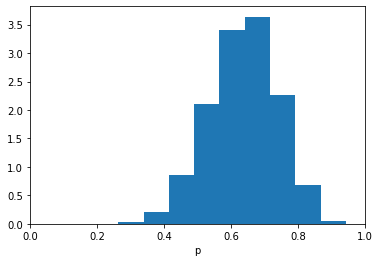

In [46]:
plt.hist(fit['p'][0], density=True)
plt.xlim((0, 1))
plt.xlabel('p')
_ = _

## Checking

In [47]:
def count_switches(tosses):
    count = 0
    for i in range(1, len(tosses)):
        if tosses[i-1] != tosses[i]:
            count += 1
    return count

In [29]:
numpy.random.randint(10)

6

A stan code block may have a `generated_quantities` section. The generated quantities can be stochastic, so this section can be used for posterior predictive sampling.

However, this involves re-implementing the model twice anyway. So, we will just implement the simulator in Python.

In [40]:
def simulate_globetoss(ps, ntosses, nsim):
    simulations = []
    for i in range(nsim):
        i = numpy.random.randint(len(ps))
        p = ps[i]
        simulations.append([numpy.random.rand() < p 
                       for _ in range(ntosses)])
    return simulations
predicted_tosses = simulate_globetoss(fit['p'][0], len(tosses), 1000)

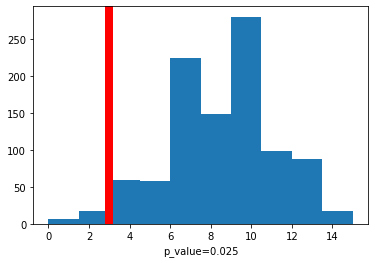

In [41]:
switches = count_switches(tosses)
predicted_switches = numpy.array([count_switches(tosses) for tosses in predicted_tosses])
p_value = len(predicted_switches[switches > predicted_switches])/len(predicted_switches)
plt.hist(predicted_switches)
plt.axvline(switches, color="red", lw=8)
plt.xlabel(f"p_value={p_value:.3f}")
_ = _

## Accounting for dependendies

### Model

In [38]:
globetoss_walk = stan.build("""
data {
    int<lower=0> N;
    int<lower=0,upper=1> tosses[N];
}

parameters {
    real<lower=0.,upper=1.> p, q;
}

model {
    p ~ beta(1, 1);
    q ~ beta(1, 1);
    tosses[1] ~ bernoulli(p);
    for (i in 2:N) {
        if (tosses[i-1] == 1) {
            tosses[i] ~ bernoulli(q + (1-q)*p);
        } else {
            tosses[i] ~ bernoulli((1-q)*p);
        }
    }
}
""", {
    'N': len(tosses),
    'tosses': tosses
})

Building...



Building: found in cache, done.

In [39]:
fit_walk = globetoss_walk.sample(num_chains=1, num_samples=5000)

Sampling:   0%
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!


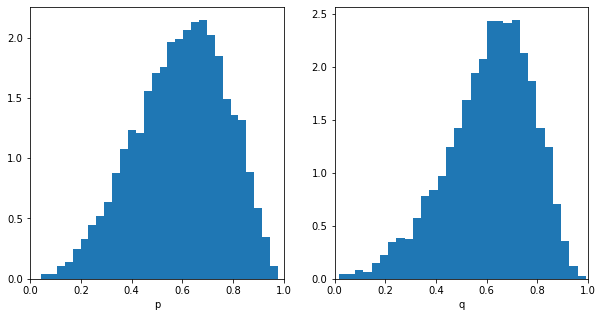

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, v in enumerate(['p', 'q']):
    ax[i].set_xlabel(v)
    ax[i].set_xlim((0, 1))
    ax[i].hist(fit_walk[v][0], bins=30, density=True)
_ = _

### Checking

In [43]:
def simulate_globetoss_walk(ps, qs, ntosses, nsim):
    simulations = []
    for i in range(nsim):
        i = numpy.random.randint(len(ps))
        p = ps[i]
        q = qs[i]
        tosses = []
        tosses.append(numpy.random.rand() < p)
        for i in range(1, ntosses):
            θ = q + (1-q)*p if tosses[-1] else (1-q)*p
            tosses.append(numpy.random.rand() < θ)
        simulations.append(tosses)
    return simulations
predicted_tosses_walk = simulate_globetoss_walk(fit_walk['p'][0], fit_walk['q'][0], len(tosses), 1000)

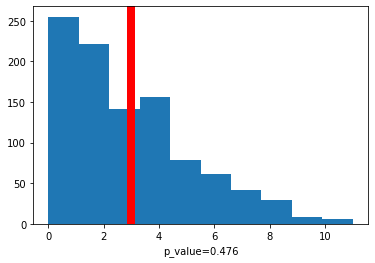

In [44]:
predicted_switches_walk = numpy.array([count_switches(tosses) for tosses in predicted_tosses_walk])
p_value_walk = len(predicted_switches_walk[switches > predicted_switches_walk])/len(predicted_switches_walk)
plt.hist(predicted_switches_walk)
plt.axvline(count_switches(tosses), color="red", lw=8)
plt.xlabel(f"p_value={p_value_walk:.3f}")
_ = _

## Basic use of ArviZ with PyStan

In [65]:
import arviz

### Plotting the posterior

<AxesSubplot:title={'center':'p'}>

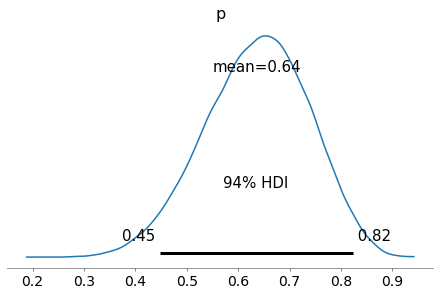

In [68]:
arviz.plot_posterior(fit)

<AxesSubplot:xlabel='p', ylabel='q'>

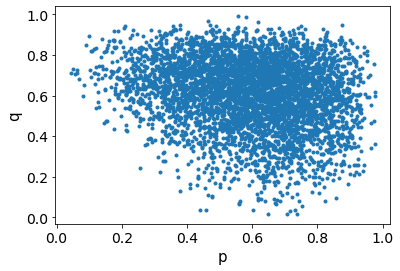

In [64]:
arviz.plot_pair(fit_walk)

### Exploring the posterior in more ways

In [70]:
arviz.from_pystan(fit_walk)

Inference data with groups:
	> posterior
	> sample_stats

ArviZ is a powerful sampler-agnostic library. You can use it with Pyro/NumPyro, PyMC3, and other frameworks.